In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# get expression matrix
genome = 'GRCm38'
bin_size = 1000
Strands = ['+', '-']
T = np.arange(0,48,4)
Nt = len(T)
Samples = ['CT{:02d}'.format(t) for t in T]
Samples = [f'{samp}{s}' for s in Strands for samp in Samples]


# get expression matrix
infile = f'../results/{genome}/binned_norm_coverage/expression_tables/bin_expression_table_bin{bin_size}bp.csv'
expression_table = pd.read_csv(infile, sep='\t')
expression_table['expression'] = expression_table.fillna(0)[Samples].sum(axis=1)
expression_table.drop(columns=Samples, inplace=True)
CHR = expression_table.chr.unique()

expressed_regions = pd.DataFrame(columns=['chr','start','end','length','dist_to_prev','dist_to_next'])
for chr in CHR:
    print(chr)
    
    # get expression values for the chromosome
    df = expression_table.loc[expression_table.chr == chr,['start','end','expression']].copy()

    # get summed expression per bin and fill in gaps
    starts = np.arange(df.start.values[0] ,df.end.values[-1],bin_size)
    ends = starts + bin_size
    df_bins = pd.DataFrame({'start':starts, 'end':ends})
    df = pd.merge(df_bins, df, on=['start','end'], how='left').fillna(0)
    df.reset_index(drop=True, inplace=True)

    # log2 transform
    df['log_expression'] = np.log2(df.expression + 1)

    # smoothing
    window = 1000
    df['smoothed_expression'] = df.log_expression.rolling(window=window, center=True).mean()
    #df.loc[df.expression == 0,'smoothed_expression'] = 0

    # get expressed regions
    threshold = 2
    df['expressed_regions'] = (df.smoothed_expression > threshold).astype(int)

    # make a dataframe with the start and end of each expressed region
    df_expressed = df[df.expressed_regions == 1].copy()[['start','end']]
    starts = np.where( df_expressed.start != df_expressed.end.shift(1) )[0]
    ends =   np.where( df_expressed.end != df_expressed.start.shift(-1) )[0]
    df_regions = pd.DataFrame({'start':df_expressed.start.iloc[starts].reset_index(drop=True),'end':df_expressed.end.iloc[ends].reset_index(drop=True)})

    # add region length and distances to the previous and next region
    df_regions['length'] = df_regions.end - df_regions.start
    df_regions['dist_to_prev'] = df_regions.start - df_regions.end.shift(1)
    df_regions['dist_to_next'] = df_regions.start.shift(-1) - df_regions.end

    # merge regions that are closer than 10kb
    th = 1e6
    idx_merge = np.where(df_regions.dist_to_next < th)[0]
    while not len(idx_merge)==0:

        # take the first region (i) to merge with the next one (i+1)
        i = idx_merge[0]
        
        # merge regions i and i+1
        df_regions.loc[i,'end'] = df_regions.loc[i+1,'end']

        # update length
        df_regions.loc[i,'length'] = df_regions.loc[i,'end'] - df_regions.loc[i,'start']

        # remove merged regions i+1
        df_regions = df_regions.loc[df_regions.end != df_regions.end.shift(-1)]
        df_regions.reset_index(drop=True, inplace=True)

        # update distances
        df_regions['dist_to_next'] = df_regions.start.shift(-1) - df_regions.end
        df_regions['dist_to_prev'] = df_regions.start - df_regions.end.shift(1)

        # check if there are more regions to merge
        assert np.all(df_regions.dist_to_next.iloc[:-1].values == df_regions.dist_to_prev.iloc[1:].values)

        # update regions to merge / check if there are more regions to merge
        idx_merge = np.where(df_regions.dist_to_next < th)[0]

    # add chromosome and append to the dataframe
    if len(df_regions) > 0:
        df_regions['chr'] = chr
        expressed_regions = pd.concat([expressed_regions,df_regions])

#expressed_regions.to_csv(f'../results/{genome}/expressed_regions/expressed_regions_bin{bin_size}bp.csv', sep='\t', index=False)


chr1
chr2


/tmp/ipykernel_3493164/1817473049.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expressed_regions = pd.concat([expressed_regions,df_regions])


chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX
chrY
chrM


In [10]:
chr

'chrM'

In [27]:
df.start.values[0]

3050000

In [11]:
df_regions

,start,end,length,dist_to_prev,dist_to_next
0,3603000,5954000,2351000,NaN,721000.0
1,6675000,11781000,5106000,721000.0,237000.0
2,12018000,14925000,2907000,237000.0,2360000.0
3,17285000,29866000,12581000,2360000.0,248000.0
4,30114000,33065000,2951000,248000.0,587000.0
5,33652000,34878000,1226000,587000.0,3772000.0
6,38650000,45763000,7113000,3772000.0,4489000.0
7,50252000,51310000,1058000,4489000.0,471000.0
8,51781000,54465000,2684000,471000.0,1231000.0
9,55696000,56628000,932000,1231000.0,660000.0


<Axes: xlabel='start'>

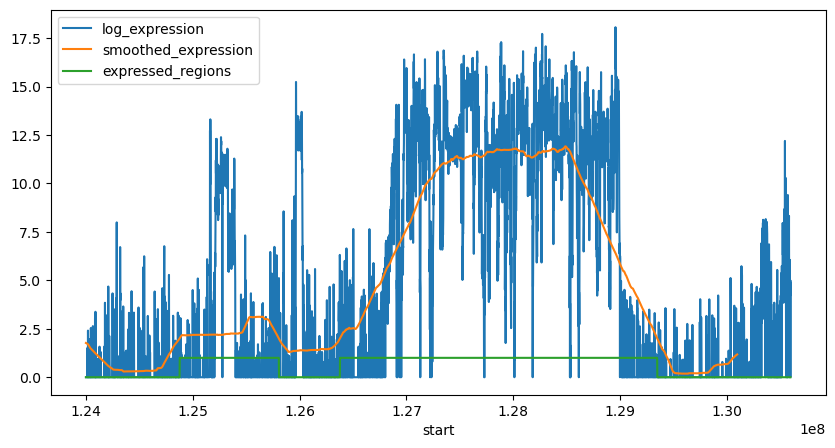

In [8]:
region = 'chr10:125,000,000-130,000,000'
chr = region.split(':')[0]
start = int(region.split(':')[1].split('-')[0].replace(',','')) - 1e6
end = int(region.split(':')[1].split('-')[1].replace(',','')) + 1e6

idx_region = df[(df.start >= start) & (df.end <= end)].index

fig, ax = plt.subplots(1,1,figsize=(10,5))
df.loc[idx_region].plot(x='start', y='log_expression', ax=ax)
df.loc[idx_region].plot(x='start', y='smoothed_expression', ax=ax)
df.loc[idx_region].plot(x='start', y='expressed_regions', ax=ax)


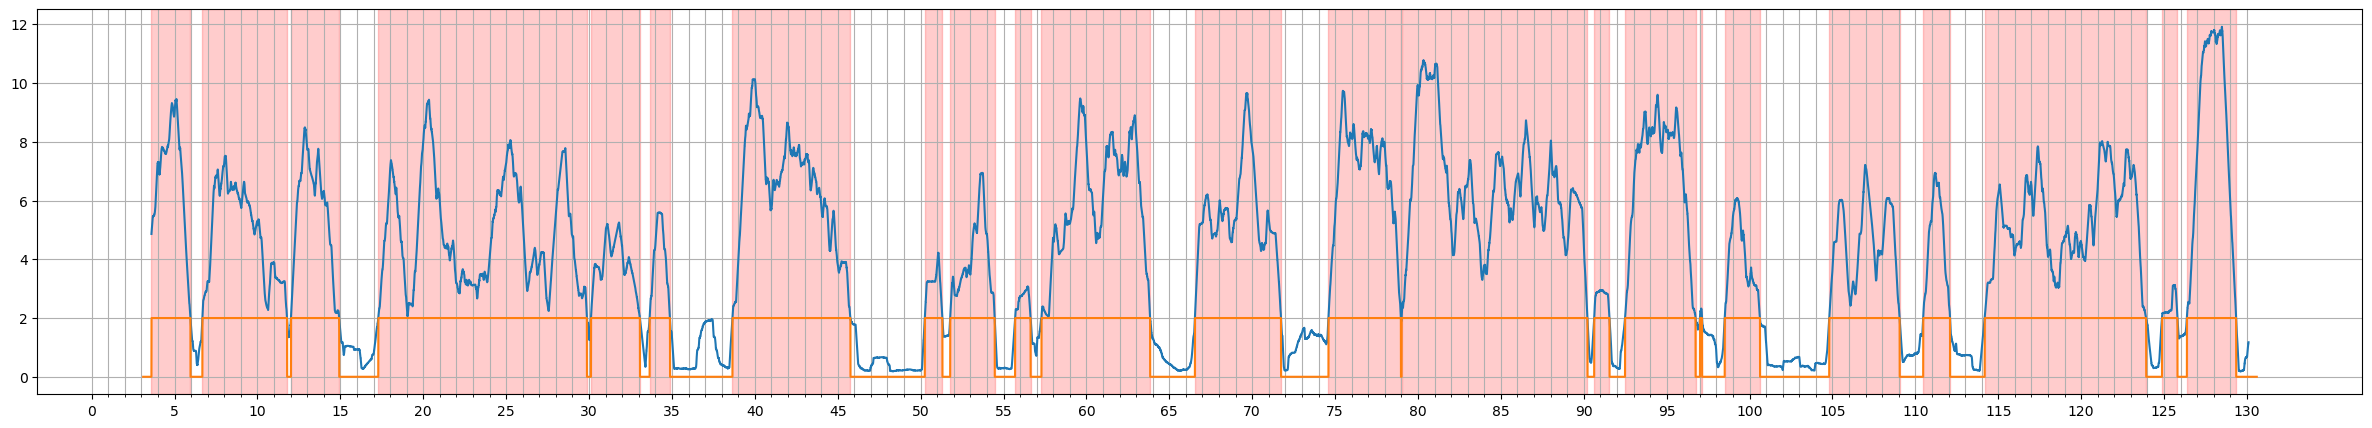

In [9]:
fig, ax = plt.subplots(1,1,figsize=(30,5))

ax.plot(df.start/1e6, df.smoothed_expression)
ax.plot(df.start/1e6, df.expressed_regions*threshold)
# put major grid every 5 Mb
_ = ax.set_xticks(np.arange(0,df.end.values[-1]/1e6,5))
# put minor grid every 1 Mb
ax.set_xticks(np.arange(0,df.end.values[-1]/1e6,1), minor=True)
ax.grid(which='both')


for i in range(len(df_regions)):
    ax.axvspan(df_regions.start.iloc[i]/1e6, df_regions.end.iloc[i]/1e6, color='red', alpha=0.2)

In [1]:
df

NameError: name 'df' is not defined

In [119]:
df.expressed_regions.values

array([0, 0, 0, ..., 0, 0, 0])

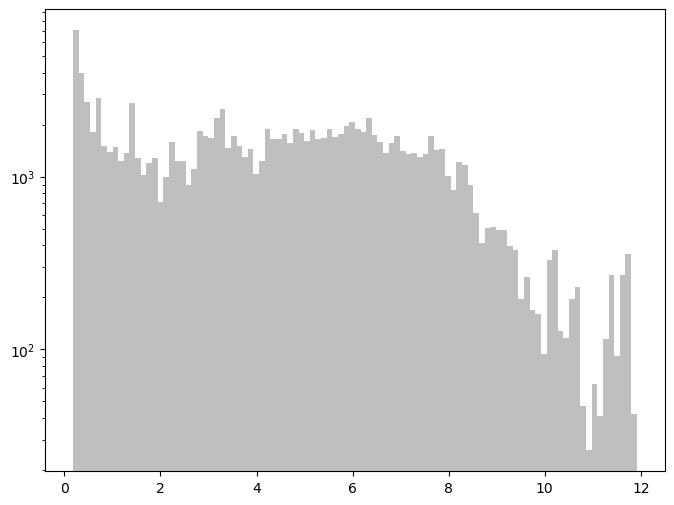

In [94]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.hist(df.smoothed_expression, bins=100, color='gray', alpha=0.5)
ax.set_yscale('log')

In [12]:
# fill in the gaps
#starts = np.arange(start, end, bin_size)

starts = np.arange(df.start[0],df.end.iloc[-1],bin_size)
X = np.zeros((len(starts),len(Samples)))
idx_chip = 

X_chip = df.loc[:,Samples].values

array([     0,     15,     25, ..., 127488, 127489, 127491])

In [23]:
df

,start,end,CT00+,CT04+,CT08+,CT12+,CT16+,CT20+,CT24+,CT28+,...,CT08-,CT12-,CT16-,CT20-,CT24-,CT28-,CT32-,CT36-,CT40-,CT44-
0,3103000,3104000,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.742735,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.00000
1,3118000,3119000,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.00000
2,3128000,3129000,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.869973,0.00000,0.0,10.32920
3,3130000,3131000,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.00000
4,3134000,3135000,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.12479,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71280,130589000,130590000,0.00000,0.0000,0.000000,0.0,0.0,0.0,5.220540,0.000000,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.00000
71281,130590000,130591000,0.00000,0.0000,12.891640,0.0,0.0,0.0,18.271900,0.000000,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.00000
71282,130591000,130592000,0.00000,10.9266,0.000000,0.0,0.0,0.0,0.870091,0.000000,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.000000,0.00000,0.0,5.63411
71283,130592000,130593000,16.85902,0.0000,0.991665,0.0,0.0,0.0,0.000000,5.199145,...,0.0,1.12479,0.0,3.18066,0.00000,0.0,0.000000,1.12635,0.0,0.00000
